In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
# import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import matplotlib.colors as colors

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")


import seawater as sw

In [2]:
# client = Client(n_workers=90)
# # client = Client(cluster)

# client = Client(n_workers=30,processes=True)
client = Client(n_workers=30,processes=True)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 30
Total threads: 150,Total memory: 502.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43289,Workers: 30
Dashboard: http://127.0.0.1:8787/status,Total threads: 150
Started: Just now,Total memory: 502.98 GiB
Comm: tcp://127.0.0.1:40569,Total threads: 5
Dashboard: http://127.0.0.1:44187/status,Memory: 16.77 GiB
Nanny: tcp://127.0.0.1:34867,


In [3]:
# chunks={'time_counter':1,'x_rho':100,"x_u":100,"x_v":100,
#                         'y_rho':152,"y_u":152,"y_v":152,'s_rho':80,'s_w':80}


# chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
#                         'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

chunks={'time_counter':1}

# chunks={'time_counter':1,'x_rho':50,"x_u":50,"x_v":50,
#                         'y_rho':152,"y_u":152,"y_v":152,'s_rho':80,'s_w':80}


path='/data/pacific/lrenault/SASI/CROCO/'

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-06*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-06*.nc',data_vars='minimal',chunks=chunks)

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)


# varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal')
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal')

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-05*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-05*.nc',data_vars='minimal',chunks=chunks)



Converting to xroms

In [4]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [5]:
nf=2 #factor of radial avg
sclstr='density'


In [6]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [7]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [8]:
nf=4
dxx=500
sclstr='density'
wdws='hann' #'flattop','hann'
wdw_cor=True
phase_bol=True
truncate_bol=True

In [9]:
# z_interp=np.linspace(z_surf_interp,-300, 41)
# z_interp=np.linspace(-60,-120,6)
z_interp=np.linspace(-100,-150,2)
# z_interp=-100

In [10]:
%%time
u_list_full=[]

i_start=0;i_end=4

for xx in range(df.u.shape[0]//4):
    u_list_full.append(df.u.xroms.isoslice(z_interp)[i_start:i_end,0,120:-120,120:750].compute())
    i_start+=4
    i_end+=4

u_i_full=xr.concat(u_list_full,dim='ocean_time')
                       
# u_z_full=df.u.xroms.isoslice(z_interp)
# u_i_full=u_z_full[:,0,60:-60,60:750].compute()


u_z_spec_full=xrft.power_spectrum(u_i_full.drop(['time_instant','nav_lat_u', 'nav_lon_u'])
                ,dim=['eta_rho','xi_u','ocean_time'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


u_z_iso_full=xrft.isotropize(u_z_spec_full,fftdim=['freq_xi_u','freq_eta_rho'],nfactor=nf,complx=False)


del u_i_full

CPU times: user 2min 34s, sys: 32.9 s, total: 3min 7s
Wall time: 12min 38s


In [11]:
%%time
v_list_full=[]
i_start=0;i_end=4

for xx in range(df.v.shape[0]//4):
    v_list_full.append(df.v.xroms.isoslice(z_interp)[i_start:i_end,0,120:-120,120:750].compute())
    i_start+=4
    i_end+=4
    
v_i_full=xr.concat(v_list_full,dim='ocean_time')

# v_z_full=df.v.xroms.isoslice(z_interp)
# v_i_full=v_z_full[:,0,60:-60,60:750].compute()

v_z_spec_full=xrft.power_spectrum(v_i_full.drop(['time_instant','nav_lat_v', 'nav_lon_v'])
                ,dim=['eta_v','xi_rho','ocean_time'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

v_z_iso_full=xrft.isotropize(v_z_spec_full,fftdim=['freq_xi_rho','freq_eta_v'],nfactor=nf,complx=False)


del v_i_full

CPU times: user 2min 39s, sys: 33.8 s, total: 3min 13s
Wall time: 12min 28s


In [12]:
%%time

u_list_smth=[]
i_start=0;i_end=4

for xx in range(dt.u.shape[0]//4):
    u_list_smth.append(dt.u.xroms.isoslice(z_interp)[i_start:i_end,0,120:-120,120:750].compute())
    i_start+=4
    i_end+=4
    
u_i_smth=xr.concat(u_list_smth,dim='ocean_time')
                       
# u_z_smth=dt.u.xroms.isoslice(z_interp)
# u_i_smth=u_z_smth[:,0,60:-60,60:750].compute()

u_z_spec_smth=xrft.power_spectrum(u_i_smth.drop(['time_instant','nav_lat_u', 'nav_lon_u'])
                ,dim=['eta_rho','xi_u','ocean_time'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

u_z_iso_smth=xrft.isotropize(u_z_spec_smth,fftdim=['freq_xi_u','freq_eta_rho'],nfactor=nf,complx=False)


del u_i_smth

CPU times: user 2min 48s, sys: 36.8 s, total: 3min 24s
Wall time: 13min 33s


In [13]:
%%time
# v_z_smth=dt.v.xroms.isoslice(z_interp)
# v_i_smth=v_z_smth[:,0,60:-60,60:750].compute()


v_list_smth=[]
i_start=0;i_end=4

for xx in range(dt.v.shape[0]//4):
    v_list_smth.append(dt.v.xroms.isoslice(z_interp)[i_start:i_end,0,120:-120,120:750].compute())
    i_start+=4
    i_end+=4

v_i_smth=xr.concat(v_list_smth,dim='ocean_time')


v_z_spec_smth=xrft.power_spectrum(v_i_smth.drop(['time_instant','nav_lat_v', 'nav_lon_v'])
                ,dim=['eta_v','xi_rho','ocean_time'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

v_z_iso_smth=xrft.isotropize(v_z_spec_smth,fftdim=['freq_xi_rho','freq_eta_v'],nfactor=nf,complx=False)

del v_i_smth

CPU times: user 2min 59s, sys: 41 s, total: 3min 40s
Wall time: 15min 13s


In [18]:

# EKE_z_full=0.5*(u_z_iso_full.data+v_z_iso_full.data)
# EKE_z_smth=0.5*(u_z_iso_smth.data+v_z_iso_smth.data)

EKE_z_full=u_z_iso_full.copy(data=0.5*(u_z_iso_full.data+v_z_iso_full.data))
EKE_z_smth=u_z_iso_smth.copy(data=0.5*(u_z_iso_smth.data+v_z_iso_smth.data))

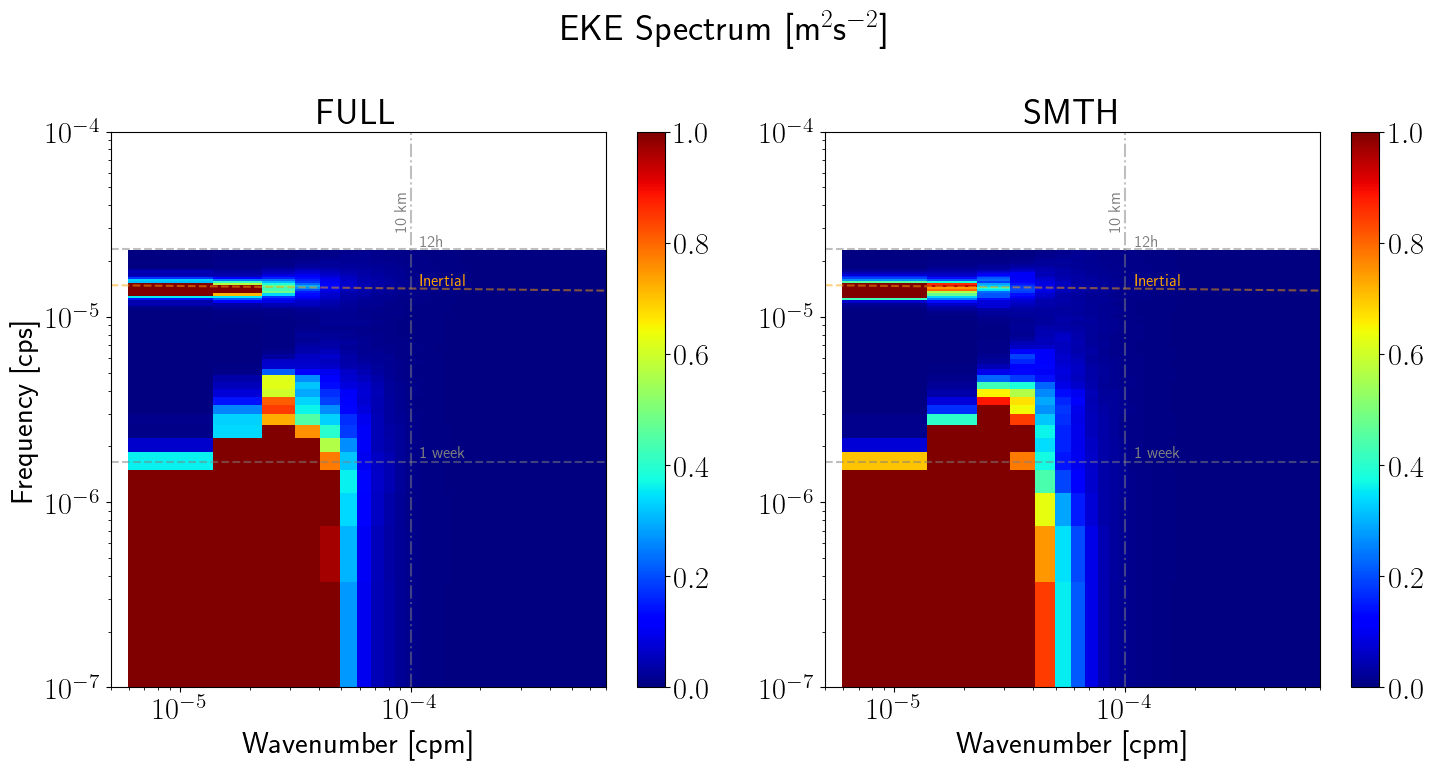

In [19]:
val_min=0
val_max=1
xmin=0.5e-5;xmax=0.7e-3;ymax=1e-4;ymin=1e-7

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.pcolormesh(EKE_z_full.freq_r/dxx,EKE_z_full.freq_ocean_time,
               ((EKE_z_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat_rho.mean()/(2*np.pi)),sw.f(vart.nav_lat_rho.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat_rho.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)

# plt.fill_between(y1=1.2e-5,y2=1.7e-5,x=EKE_z_smth.freq_r/dxx,color='white',alpha=0.3)


plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.3e-4,r'10 km',color='gray',fontsize=12,rotation=90)

# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)




plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(EKE_z_smth.freq_r/dxx,EKE_z_smth.freq_ocean_time,
               ((EKE_z_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat_rho.mean()/(2*np.pi)),sw.f(vart.nav_lat_rho.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)


# plt.fill_between(y1=1.2e-5,y2=1.7e-5,x=EKE_z_smth.freq_r/dxx,color='white',alpha=0.3)

plt.text(1.1e-4,sw.f(vart.nav_lat_rho.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.3e-4,r'10 km',color='gray',fontsize=12,rotation=90)

# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.suptitle(r'EKE Spectrum [m$^2$s$^{-2}$]')

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

In [20]:
# band_EKE_full=(EKE_z_full).sel(freq_ocean_time=slice(1.39e-5,1.74e-5))
# band_EKE_smth=(EKE_z_smth).sel(freq_ocean_time=slice(1.39e-5,1.74e-5))

band_EKE_full=(EKE_z_full).sel(freq_ocean_time=slice(1.2e-5,1.7e-5))
band_EKE_smth=(EKE_z_smth).sel(freq_ocean_time=slice(1.2e-5,1.7e-5))

Text(0.5, 0, 'Wavenumber [cpm]')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


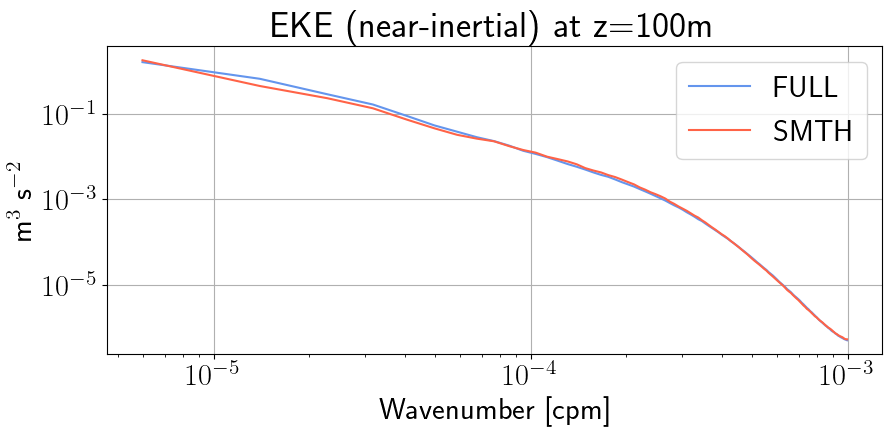

In [21]:
plt.figure(figsize=(10,4))
plt.plot(band_EKE_full.freq_r/dxx,band_EKE_full.mean('freq_ocean_time')/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_EKE_smth.freq_r/dxx,band_EKE_smth.mean('freq_ocean_time')/dxx,label='SMTH',color='tomato')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
plt.grid()
# plt.xlim(1e-5,1e-3)
# plt.ylim(5e-4,2e-1)
plt.title('EKE (near-inertial) at z=100m')
plt.ylabel(r'm$^3$ s$^{-2}$ ')
plt.xlabel(r'Wavenumber [cpm]')




